In [1]:
import torch
import numpy as np
from torchsummary import summary

from data import FlagDataset
from torch.utils.data import DataLoader
from utils import get_device
from model import Encoder, Decoder

In [2]:
DEVICE = get_device()

In [4]:
flag_dataset = FlagDataset("flags", device=DEVICE)
print(flag_dataset.device)

flag_dataloader = DataLoader(flag_dataset, batch_size=32, shuffle=True)
def cycle(iterable, n):
    while True:
        for x in iterable:
            yield x

cuda


In [5]:
latent_size = 64
encoder = Encoder(128, latent_size=latent_size).to(DEVICE)
pre_flatten_size = encoder.pre_flatten_size
print(latent_size, pre_flatten_size)
decoder = Decoder(latent_size, pre_flatten_size).to(DEVICE)

summary(encoder, (4, 128, 128))
summary(decoder, (latent_size,))

64 torch.Size([32, 2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           4,736
              ReLU-2        [-1, 128, 128, 128]               0
         MaxPool2d-3          [-1, 128, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          73,792
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]         102,464
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 32, 4, 4]          51,232
             ReLU-11             [-1, 32, 4, 4]               0
        MaxPool2d-12             [-1, 32, 2, 2]               0
           Linear-13                   [-1, 64]           8,256
          Sig

In [7]:
encoder.load_state_dict(torch.load("encoder.pth", weights_only=True))
decoder.load_state_dict(torch.load("decoder.pth", weights_only=True))

<All keys matched successfully>

In [8]:
batches = 1000

encoder.train()
decoder.train()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
running_loss = 0
print_every = 100
for i, batch in enumerate(cycle(flag_dataloader, batches)):
    optimizer.zero_grad()
    x = batch[0]
    z = encoder(x)
    x_hat = decoder(z)
    
    loss = torch.nn.functional.binary_cross_entropy(x_hat, x)
    loss.backward()
    running_loss += loss.item()
    
    if i % print_every == 0:
        print(f"Batch {i}: Loss {running_loss / print_every}")
        running_loss = 0
    
    optimizer.step()

Batch 0: Loss 0.0015564113855361938
Batch 100: Loss 0.16682524666190146
Batch 200: Loss 0.15330007389187814
Batch 300: Loss 0.15358181551098823
Batch 400: Loss 0.1534163075685501
Batch 500: Loss 0.15345469430088998
Batch 600: Loss 0.1532118996977806
Batch 700: Loss 0.15323636919260025
Batch 800: Loss 0.1541201014816761
Batch 900: Loss 0.15360671371221543
Batch 1000: Loss 0.15358060881495475
Batch 1100: Loss 0.15391144797205925
Batch 1200: Loss 0.15450437486171723
Batch 1300: Loss 0.155281902551651
Batch 1400: Loss 0.1547008113563061
Batch 1500: Loss 0.15460119858384133
Batch 1600: Loss 0.15318257600069046
Batch 1700: Loss 0.15368891313672065
Batch 1800: Loss 0.1540265703201294
Batch 1900: Loss 0.1535256277024746
Batch 2000: Loss 0.15657255172729492
Batch 2100: Loss 0.1533462043106556
Batch 2200: Loss 0.1530403871834278
Batch 2300: Loss 0.15318054616451263
Batch 2400: Loss 0.15501606836915016
Batch 2500: Loss 0.15376787021756172
Batch 2600: Loss 0.15468112021684646
Batch 2700: Loss 0.15

KeyboardInterrupt: 

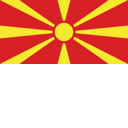

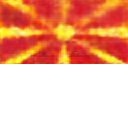

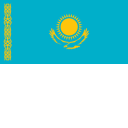

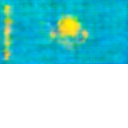

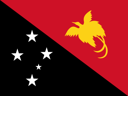

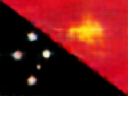

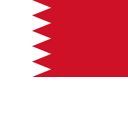

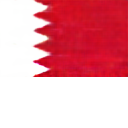

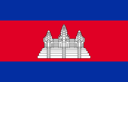

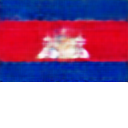

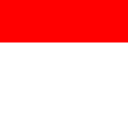

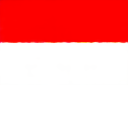

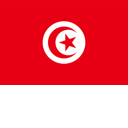

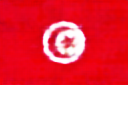

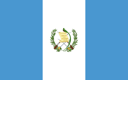

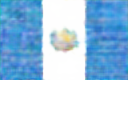

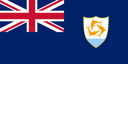

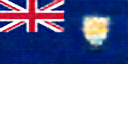

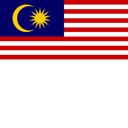

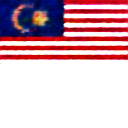

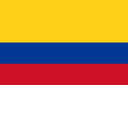

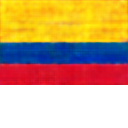

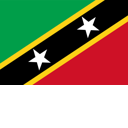

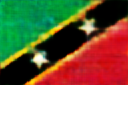

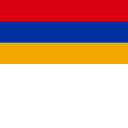

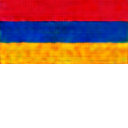

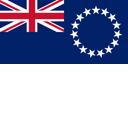

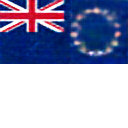

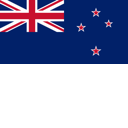

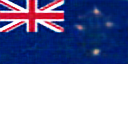

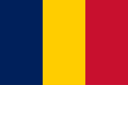

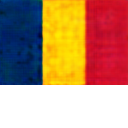

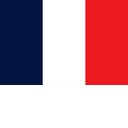

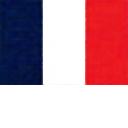

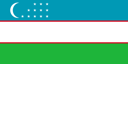

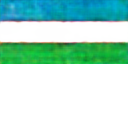

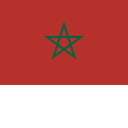

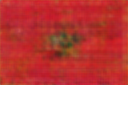

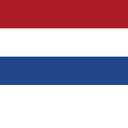

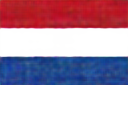

In [10]:
encoder.eval()
decoder.eval()
from PIL import Image
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

for i in range(20):
    x = flag_dataset[i][0]
    to_pil(x).show()
    z = encoder(x.unsqueeze(0))
    #z = z + (torch.randn_like(z)-0.5)*0.1
    im = decoder(z).squeeze(0)
    im = to_pil(im)
    im.show()

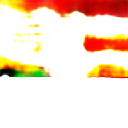

In [ ]:
x = torch.rand(latent_size).to(DEVICE)
x = x.round()
im = decoder(x.unsqueeze(0)).squeeze(0)
im = to_pil(im)
im.show()

In [11]:
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")